In [1]:
import pandas as pd
from collections import deque

In [2]:
dir(deque)

['__add__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__copy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'appendleft',
 'clear',
 'copy',
 'count',
 'extend',
 'extendleft',
 'index',
 'insert',
 'maxlen',
 'pop',
 'popleft',
 'remove',
 'reverse',
 'rotate']

# 函数测试

In [138]:
df = pd.DataFrame({'acfdid': [1, 1, 1, 2, 2, 2, 2, 2], 'amt': [100, 100, -150, 50, 150, -150, 50, -200], 'price': [20, 30, 40, 20, 30, 40, 20, 0]})
df

,acfdid,amt,price
0,1,100,20
1,1,100,30
2,1,-150,40
3,2,50,20
4,2,150,30
5,2,-150,40
6,2,50,20
7,2,-200,0


In [3]:
def fifo(data):
    stack, res = [], []
    tot_amt, tot_val = 0, 0
    for v, p in zip(data['amt'], data['price']):
        while v < 0:  # 减少仓位
            if stack: _p, _v = stack[0]  # 取出底部库存
            else:  # 异常数据处理，说明是空仓
                tot_amt -= v  # 欠着这些amt
                tot_val = 0  # 空了那库存价值就归零了
                break
            if v + _v < 0:
                v += _v
                tot_amt -= _v
                tot_val -= _v * _p
                stack.pop(0)  # 删去底部库存
            else:
                _v += v
                tot_amt += v
                tot_val += v * _p
                v = 0
                stack[0] = (_p , _v)  # 更新底部库存
        if v > 0:
            stack.append((p, v))
            tot_amt += v
            tot_val += v * p

        if tot_amt == 0: res.append(0)  # 表示空仓，成本按0计
        else: res.append(tot_val / tot_amt)
    data['fifo'] = res
    return data

In [4]:
def fifo2(data):
    stack, res = deque(), []
    tot_amt, tot_val = 0, 0
    for v, p in zip(data['amt'], data['price']):
        while v < 0:  # 减少仓位
            if stack: _p, _v = stack[0]  # 取出底部库存
            else:  # 异常数据处理，说明是空仓
                tot_amt -= v  # 欠着这些amt
                tot_val = 0  # 空了那库存价值就归零了
                break

            if v + _v < 0:
                v += _v
                tot_amt -= _v
                tot_val -= _v * _p
                stack.popleft()  # 删去底部库存
            else:
                _v += v
                tot_amt += v
                tot_val += v * _p
                v = 0
                stack[0] = (_p , _v)  # 更新底部库存
        if v > 0:
            stack.append((p, v))
            tot_amt += v
            tot_val += v * p

        if tot_amt == 0: res.append(0)  # 表示空仓，成本按0计
        else: res.append(tot_val / tot_amt)
    data['fifo'] = res
    return data

In [140]:
df = df.groupby('acfdid').apply(fifo)
df

,acfdid,amt,price,fifo
0,1,100,20,20.0
1,1,100,30,25.0
2,1,-150,40,30.0
3,2,50,20,20.0
4,2,150,30,27.5
5,2,-150,40,30.0
6,2,50,20,25.0
7,2,-200,0,0.0


# 实际数据

In [5]:
df = pd.read_stata('data.dta')
df.sort_values(by=['acfdid', '确认日期'], inplace=True)
df['price'] = df['jine'] / df['Amt']
df['amt'] = df['fuhao'] * df['Amt']
df['cumamt'] = df.groupby('acfdid')['amt'].cumsum()
df.shape
df.sample(3)

(2830, 8)

,确认日期,Amt,jine,acfdid,fuhao,price,amt,cumamt
1046,2016-06-27,37996698.59,38004020.54,1021001233,-1.0,1.000193,-37996698.59,-496698.59
1264,2017-10-18,1747.82,1747.99,1091001232,-1.0,1.000097,-1747.82,-1747.82
2564,2017-01-06,50000.00,50000.00,1456001233,1.0,1.000000,50000.00,0.00


<AxesSubplot:>

312

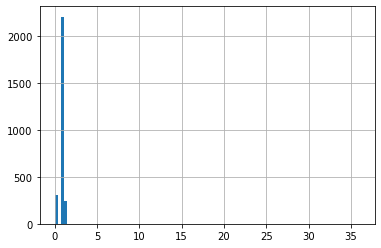

In [6]:
df.loc[df['Amt'] != 0, 'price'].hist(bins=100)
sum(df['price'] == 0)

In [7]:
%%timeit
df.groupby(['acfdid']).apply(fifo)  # 速度测试——慢

619 ms ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
df.groupby(['acfdid']).apply(fifo2)  # 速度测试——慢

614 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [145]:
df = df.groupby(['acfdid']).apply(fifo)

In [146]:
uid = df.sample()['acfdid'].values[0]
df.loc[df['acfdid'] == uid]

,确认日期,Amt,jine,acfdid,fuhao,price,amt,cumamt,fifo
1589,2016-07-06,1.000000e+08,1.000000e+08,1161001233,1.0,1.000000,1.000000e+08,1.000000e+08,1.000000
1575,2016-07-12,2.000000e+08,2.000000e+08,1161001233,1.0,1.000000,2.000000e+08,3.000000e+08,1.000000
1585,2016-08-11,2.000000e+08,2.000000e+08,1161001233,1.0,1.000000,2.000000e+08,5.000000e+08,1.000000
1594,2016-09-07,5.017805e+08,5.018501e+08,1161001233,-1.0,1.000139,-5.017805e+08,-1.780538e+06,0.000000
1592,2016-09-09,3.000000e+08,3.000000e+08,1161001233,1.0,1.000000,3.000000e+08,2.982195e+08,0.994100
1584,2016-10-10,3.007844e+08,3.011166e+08,1161001233,-1.0,1.001105,-3.007844e+08,-2.564918e+06,0.000000
1601,2016-10-20,1.000000e+08,1.000000e+08,1161001233,1.0,1.000000,1.000000e+08,9.743508e+07,0.974992
1597,2016-11-23,1.002347e+08,1.002403e+08,1161001233,-1.0,1.000055,-1.002347e+08,-2.799667e+06,0.000000
1588,2017-01-26,1.000000e+08,1.000000e+08,1161001233,1.0,1.000000,1.000000e+08,9.720033e+07,0.972766
1577,2017-03-03,2.000000e+08,2.000000e+08,1161001233,1.0,1.000000,2.000000e+08,2.972003e+08,0.990754


<AxesSubplot:>

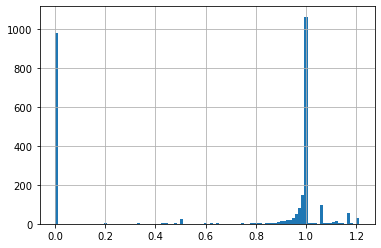

In [147]:
df.loc[df['Amt'] != 0, 'fifo'].hist(bins=100)